In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from joblib import dump, load
from datetime import datetime
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

Loading the dataset & a quick glance


In [2]:
Claims_data = pd.read_csv('FNOL_DATA\claims_table.csv')
Policy_data = pd.read_csv('FNOL_DATA\policyholder_table.csv')

In [3]:
Claims_data.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy


In [4]:
Policy_data.head()

,Policy_ID,Customer_ID,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,POL_000001,CUST_77820,1983-04-20,2003-08-23,Sedan,2008
1,POL_000002,CUST_88498,1986-03-10,2007-07-26,Hatchback,2012
2,POL_000003,CUST_60735,1971-03-02,1989-07-05,Hatchback,2021
3,POL_000004,CUST_54707,1946-09-19,1968-01-12,Truck,2022
4,POL_000005,CUST_26658,1957-07-26,1977-08-07,SUV,2006


## 1. Data Preparation


Merge the dataset: Join the Claims dataset and Policy dataset using Policy_ID and Customer_ID to get a unified dataset.

Data Cleaning

- Dates: convert the dates to datetime format

- Handle missing values (.fillna() or dropna())

- Duplicates



Feature Engineering

- Reporting_Delay = FNOL_Date - Accident_Date
- Settlement_Delay = Settlement_Date - FNOL_Date
- Total_Delay = Reporting_Delay + Settlement_Delay

- Vehicle_age_at_accident = Accident_Date - Vehicle_Year
- Licence_age_at_accident = Accident_Date - Full_License_Issue_Date
- Customer_age_at_accident = Accident_Date - Date_of_Birth

- Accuracy_Check = Estimated_Claim_Amount = Ultimate_Claim_Amount

In [5]:
# checking the shape of the datasets before merging

print(f"Rows and columns contained in Claims dataset: {Claims_data.shape}")
print(f"Rows and columns contained in Policy dataset: {Policy_data.shape}")

Rows and columns contained in Claims dataset: (146987, 11)
Rows and columns contained in Policy dataset: (120000, 6)


In [6]:
# Merge both dataset

Claims_df = pd.merge(Claims_data, Policy_data, on=['Policy_ID', 'Customer_ID'])
Claims_df.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,1983-04-20,2003-08-23,Sedan,2008
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,1986-03-10,2007-07-26,Hatchback,2012
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,1971-03-02,1989-07-05,Hatchback,2021
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,1971-03-02,1989-07-05,Hatchback,2021
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy,1971-03-02,1989-07-05,Hatchback,2021


In [7]:
print(f"Rows and columns contained in merged dataset: {Claims_df.shape}")
print(f"\n Rows and columns contained in Claims dataset:\n {Claims_df.columns}")

Rows and columns contained in merged dataset: (146987, 15)

 Rows and columns contained in Claims dataset:
 Index(['Claim_ID', 'Policy_ID', 'Customer_ID', 'Accident_Date', 'FNOL_Date',
       'Claim_Type', 'Estimated_Claim_Amount', 'Ultimate_Claim_Amount',
       'Settlement_Date', 'Traffic_Condition', 'Weather_Condition',
       'Date_of_Birth', 'Full_License_Issue_Date', 'Vehicle_Type',
       'Vehicle_Year'],
      dtype='object')


In [8]:
# Merge both dataset using pd.concat

Claims1 = pd.concat([Claims_data, Policy_data.set_index(['Customer_ID', 'Policy_ID'])], join= 'outer', axis=1 )
Claims1.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,NaN,NaN,NaN,NaN
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,NaN,NaN,NaN,NaN
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,NaN,NaN,NaN,NaN
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,NaN,NaN,NaN,NaN
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy,NaN,NaN,NaN,NaN


In [9]:

print(f"Rows and columns contained in merged dataset: {Claims1.shape}")
print(f"\n Rows and columns contained in Claims dataset:\n {Claims1.columns}")

Rows and columns contained in merged dataset: (266987, 15)

 Rows and columns contained in Claims dataset:
 Index(['Claim_ID', 'Policy_ID', 'Customer_ID', 'Accident_Date', 'FNOL_Date',
       'Claim_Type', 'Estimated_Claim_Amount', 'Ultimate_Claim_Amount',
       'Settlement_Date', 'Traffic_Condition', 'Weather_Condition',
       'Date_of_Birth', 'Full_License_Issue_Date', 'Vehicle_Type',
       'Vehicle_Year'],
      dtype='object')


### Data Cleaning

In [10]:
#Checking the dataset information
Claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Claim_ID                 146987 non-null  object 
 1   Policy_ID                146987 non-null  object 
 2   Customer_ID              146987 non-null  object 
 3   Accident_Date            146987 non-null  object 
 4   FNOL_Date                146987 non-null  object 
 5   Claim_Type               146987 non-null  object 
 6   Estimated_Claim_Amount   143989 non-null  float64
 7   Ultimate_Claim_Amount    144065 non-null  float64
 8   Settlement_Date          146987 non-null  object 
 9   Traffic_Condition        144027 non-null  object 
 10  Weather_Condition        143950 non-null  object 
 11  Date_of_Birth            146987 non-null  object 
 12  Full_License_Issue_Date  146987 non-null  object 
 13  Vehicle_Type             146987 non-null  object 
 14  Vehi

In [11]:
# Checking decriptive details
Claims_df.describe(include='all')

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
count,146987,146987,146987,146987,146987,146987,143989.000000,144065.00000,146987,144027,143950,146987,146987,146987,146987.000000
unique,146987,120000,69449,1825,1855,7,NaN,NaN,2099,4,5,22536,24036,6,NaN
top,CLM_000001,POL_026408,CUST_25647,2023-12-31,2020-04-28,collision,NaN,NaN,2024-09-20,Moderate,Rainy,1994-09-08,1998-05-27,Sedan,NaN
freq,1,7,12,116,116,66268,NaN,NaN,107,72074,57579,24,25,51180,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,17893.981440,17550.85741,NaN,NaN,NaN,NaN,NaN,NaN,2012.479906
std,NaN,NaN,NaN,NaN,NaN,NaN,24946.567916,21131.49158,NaN,NaN,NaN,NaN,NaN,NaN,5.776185
min,NaN,NaN,NaN,NaN,NaN,NaN,341.490000,450.00000,NaN,NaN,NaN,NaN,NaN,NaN,2003.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,4567.660000,4829.19000,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,10355.420000,10965.84000,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,20549.920000,19800.00000,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000


Checking for missing values

In [12]:
#Checking for missing values

Claims_df.isnull().sum()

Claim_ID                      0
Policy_ID                     0
Customer_ID                   0
Accident_Date                 0
FNOL_Date                     0
Claim_Type                    0
Estimated_Claim_Amount     2998
Ultimate_Claim_Amount      2922
Settlement_Date               0
Traffic_Condition          2960
Weather_Condition          3037
Date_of_Birth                 0
Full_License_Issue_Date       0
Vehicle_Type                  0
Vehicle_Year                  0
dtype: int64

Fixing the date columns - convert to datatime

In [13]:
# saving date columns in a variable 

Date_cols = ['Accident_Date', 'FNOL_Date', 'Settlement_Date', 'Date_of_Birth', 'Full_License_Issue_Date']

# Convert to datetime
Claims_df[Date_cols] = Claims_df[Date_cols].apply(pd.to_datetime, errors = 'coerce')


Fixing missing values


In [14]:
# Checking Datatypes of columns with missing values

Missing_cols = Claims_df.columns[Claims_df.isna().any()]
for col in Missing_cols:
    print(f"{col}: {Claims_df[col].dtypes}")

Estimated_Claim_Amount: float64
Ultimate_Claim_Amount: float64
Traffic_Condition: object
Weather_Condition: object


In [15]:
# Input numerical columns usin median
for col in ['Estimated_Claim_Amount', 'Ultimate_Claim_Amount' ]:
    Claims_df[col] = Claims_df[col].fillna(Claims_df[col].median())


# Input categorical columns using mode
for col in ['Traffic_Condition', 'Weather_Condition' ]:
    Claims_df[col] = Claims_df[col].fillna(Claims_df[col].mode()[0])



Checking dataset after fixing the issues

In [16]:

print(Claims_df.isna().sum())

Claim_ID                   0
Policy_ID                  0
Customer_ID                0
Accident_Date              0
FNOL_Date                  0
Claim_Type                 0
Estimated_Claim_Amount     0
Ultimate_Claim_Amount      0
Settlement_Date            0
Traffic_Condition          0
Weather_Condition          0
Date_of_Birth              0
Full_License_Issue_Date    0
Vehicle_Type               0
Vehicle_Year               0
dtype: int64


In [17]:
Claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Claim_ID                 146987 non-null  object        
 1   Policy_ID                146987 non-null  object        
 2   Customer_ID              146987 non-null  object        
 3   Accident_Date            146987 non-null  datetime64[ns]
 4   FNOL_Date                146987 non-null  datetime64[ns]
 5   Claim_Type               146987 non-null  object        
 6   Estimated_Claim_Amount   146987 non-null  float64       
 7   Ultimate_Claim_Amount    146987 non-null  float64       
 8   Settlement_Date          146987 non-null  datetime64[ns]
 9   Traffic_Condition        146987 non-null  object        
 10  Weather_Condition        146987 non-null  object        
 11  Date_of_Birth            146987 non-null  datetime64[ns]
 12  Full_License_Iss

Checking for duplicates

In [18]:
Claims_df.duplicated().sum()

np.int64(0)

### Feature Engineering

- Reporting_Delay = FNOL_Date - Accident_Date
- Settlement_Delay = Settlement_Date - FNOL_Date
- Total_Claim_duration = Reporting_Delay + Settlement_Delay

- Vehicle_age_at_accident = Accident_Date - Vehicle_Year
- Licence_age_at_accident = Accident_Date - Full_License_Issue_Date
- Customer_age_at_accident = Accident_Date - Date_of_Birth

- Accuracy_Check = Estimated_Claim_Amount = Ultimate_Claim_Amount

In [19]:
# Deriving Driver's age at accident
Claims_df["Driver_age_(years)"] = (Claims_df["Accident_Date"] - Claims_df["Date_of_Birth"]).dt.days // 365
# Deriving License age at accident
Claims_df["License_age_(years)"] = (Claims_df["Accident_Date"] - Claims_df["Full_License_Issue_Date"]).dt.days // 365
# Deriving Vehicle age
Claims_df["Vehicle_age_(years)"] = Claims_df["Accident_Date"].dt.year - Claims_df['Vehicle_Year']


# Deriving Reporting delay feature
Claims_df["FNOL_delay_(days)"] = (Claims_df["FNOL_Date"] - Claims_df["Accident_Date"]).dt.days
# Settlement days feature
Claims_df["Settlement_days"] = (Claims_df["Settlement_Date"] - Claims_df["FNOL_Date"]).dt.days
# Total claim duration in days
Claims_df["Claim_duration_(days)"] = Claims_df["Settlement_days"] - Claims_df["FNOL_delay_(days)"]


# Checking Accuracy of claim estimation
Claims_df["Claim_accuracy_Check"] = Claims_df["Estimated_Claim_Amount"] == Claims_df["Ultimate_Claim_Amount"]

In [20]:
# Check dataset after feature engineering
Claims_df.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,...,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year,Driver_age_(years),License_age_(years),Vehicle_age_(years),FNOL_delay_(days),Settlement_days,Claim_duration_(days),Claim_accuracy_Check
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,...,2003-08-23,Sedan,2008,36,16,12,4,112,108,False
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,...,2007-07-26,Hatchback,2012,36,15,11,1,70,69,False
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,...,1989-07-05,Hatchback,2021,51,33,1,1,37,36,False
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,...,1989-07-05,Hatchback,2021,50,32,0,5,14,9,False
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,10965.84,2022-12-06,Moderate,...,1989-07-05,Hatchback,2021,51,33,1,7,59,52,False


In [21]:

Claims_df["Claim_accuracy_Check"].value_counts()

Claim_accuracy_Check
False    146985
True          2
Name: count, dtype: int64

In [22]:
Claims_df.columns.value_counts()

Claim_ID                   1
Policy_ID                  1
Customer_ID                1
Accident_Date              1
FNOL_Date                  1
Claim_Type                 1
Estimated_Claim_Amount     1
Ultimate_Claim_Amount      1
Settlement_Date            1
Traffic_Condition          1
Weather_Condition          1
Date_of_Birth              1
Full_License_Issue_Date    1
Vehicle_Type               1
Vehicle_Year               1
Driver_age_(years)         1
License_age_(years)        1
Vehicle_age_(years)        1
FNOL_delay_(days)          1
Settlement_days            1
Claim_duration_(days)      1
Claim_accuracy_Check       1
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

Basic Insights

1. Total value of Ultimate_Claim_Amount

2. Identify highest and lowest Ultimate_Claim_Amount.

3. Examine driver age range (Driver_age).

4. Identify the longest & shortest FNOL_delay

5. Longest & quickest settlement duration

6. Identify most frequent Traffic_Condition and Weather_Condition.




In [ ]:
print("Dataset Overview")
print("="*100)
print(f"Total Claims value: £{Claims_df["Ultimate_Claim_Amount"].sum():,.2f}")
print(f"Highest Ultimate Claim is £{Claims_df["Ultimate_Claim_Amount"].max():,.2f} while Lowest Ultimate Claim is £{Claims_df["Ultimate_Claim_Amount"].min():,.2f}")
print(f"Oldest Driver is {Claims_df["Driver_age_(years)"].max()} while Youngest Driver is {Claims_df["Driver_age_(years)"].min()}")
print(f"Longest FNOL delay is {Claims_df["FNOL_delay_(days)"].max()} while Shortest FNOL delay is {Claims_df["FNOL_delay_(days)"].min()}")
print(f"Longest Settlement delay is {Claims_df["Settlement_days"].max()} while Shortest Settlement delay is {Claims_df["Settlement_days"].min()}")
print("="*100)
print(f"Traffic condition counts is: \n {Claims_df["Traffic_Condition"].value_counts()}")
print("\n")
print(f"Weather condition counts is \n {Claims_df["Weather_Condition"].value_counts()}")
print("="*100)
print("Weather condition and impact on claim amounts")
weather_impact_amounts = Claims_df.groupby("Weather_Condition").agg({
    "Estimated_Claim_Amount": "sum",
    "Ultimate_Claim_Amount": "sum"
}).reset_index()
weather_impact_amounts = weather_impact_amounts.sort_values("Ultimate_Claim_Amount", ascending = False)
display(weather_impact_amounts.head())
print("="*100)
print("Claim types and associated claim amounts")
claim_type_amounts = Claims_df.groupby("Claim_Type").agg({
    "Estimated_Claim_Amount": "sum",
    "Ultimate_Claim_Amount": "sum"
}).reset_index()
display(claim_type_amounts)
print(f"The claim type with lowest amount is {claim_type_amounts.loc[claim_type_amounts['Estimated_Claim_Amount'].idxmin(), 'Claim_Type']} with total amount of £{claim_type_amounts["Estimated_Claim_Amount"].min():,}")
print(f"The claim type with highest amount is {claim_type_amounts.loc[claim_type_amounts['Estimated_Claim_Amount'].idxmax(), 'Claim_Type']} with total amount of £{claim_type_amounts["Estimated_Claim_Amount"].max():,}")

Dataset Overview
Total Claims value: £2,560,506,457.20
Highest Ultimate Claim is £234,000.00 while Lowest Ultimate Claim is £450.00
Oldest Driver is 84 while Youngest Driver is 18
Longest FNOL delay is 30 while Shortest FNOL delay is 0
Longest Settlement delay is 364 while Shortest Settlement delay is 7
Traffic condition counts is Traffic_Condition
Moderate    75034
High        36104
Low         28647
Severe       7202
Name: count, dtype: int64


Weather condition counts is Weather_Condition
Rainy     60616
Foggy     28884
Snowy     28771
Stormy    14433
Clear     14283
Name: count, dtype: int64
Weather condition and impact on claim amounts


,Weather_Condition,Estimated_Claim_Amount,Ultimate_Claim_Amount
2,Rainy,1.080873e+09,1.059460e+09
1,Foggy,5.133216e+08,5.030657e+08
3,Snowy,5.053553e+08,4.972387e+08
4,Stormy,2.553265e+08,2.522643e+08
0,Clear,2.527053e+08,2.484780e+08


Claim types and associated claim amounts


,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount
0,animal_collision,4.199488e+07,4.197195e+07
1,bodily_injury,6.582306e+08,6.209487e+08
2,collision,7.526246e+08,7.520664e+08
3,fire,5.532218e+08,5.447757e+08
4,glass,2.294494e+07,2.296694e+07
5,theft,5.194864e+08,5.183247e+08
6,vandalism,5.907897e+07,5.945203e+07


The claim type with lowest amount is glass with total amount of £22,944,939.03
The claim type with highest amount is collision with total amount of £752,624,572.44


### Visualizations

Univariate

Distribution plots - Numerical 


Text(0.5, 0, 'Number of days')

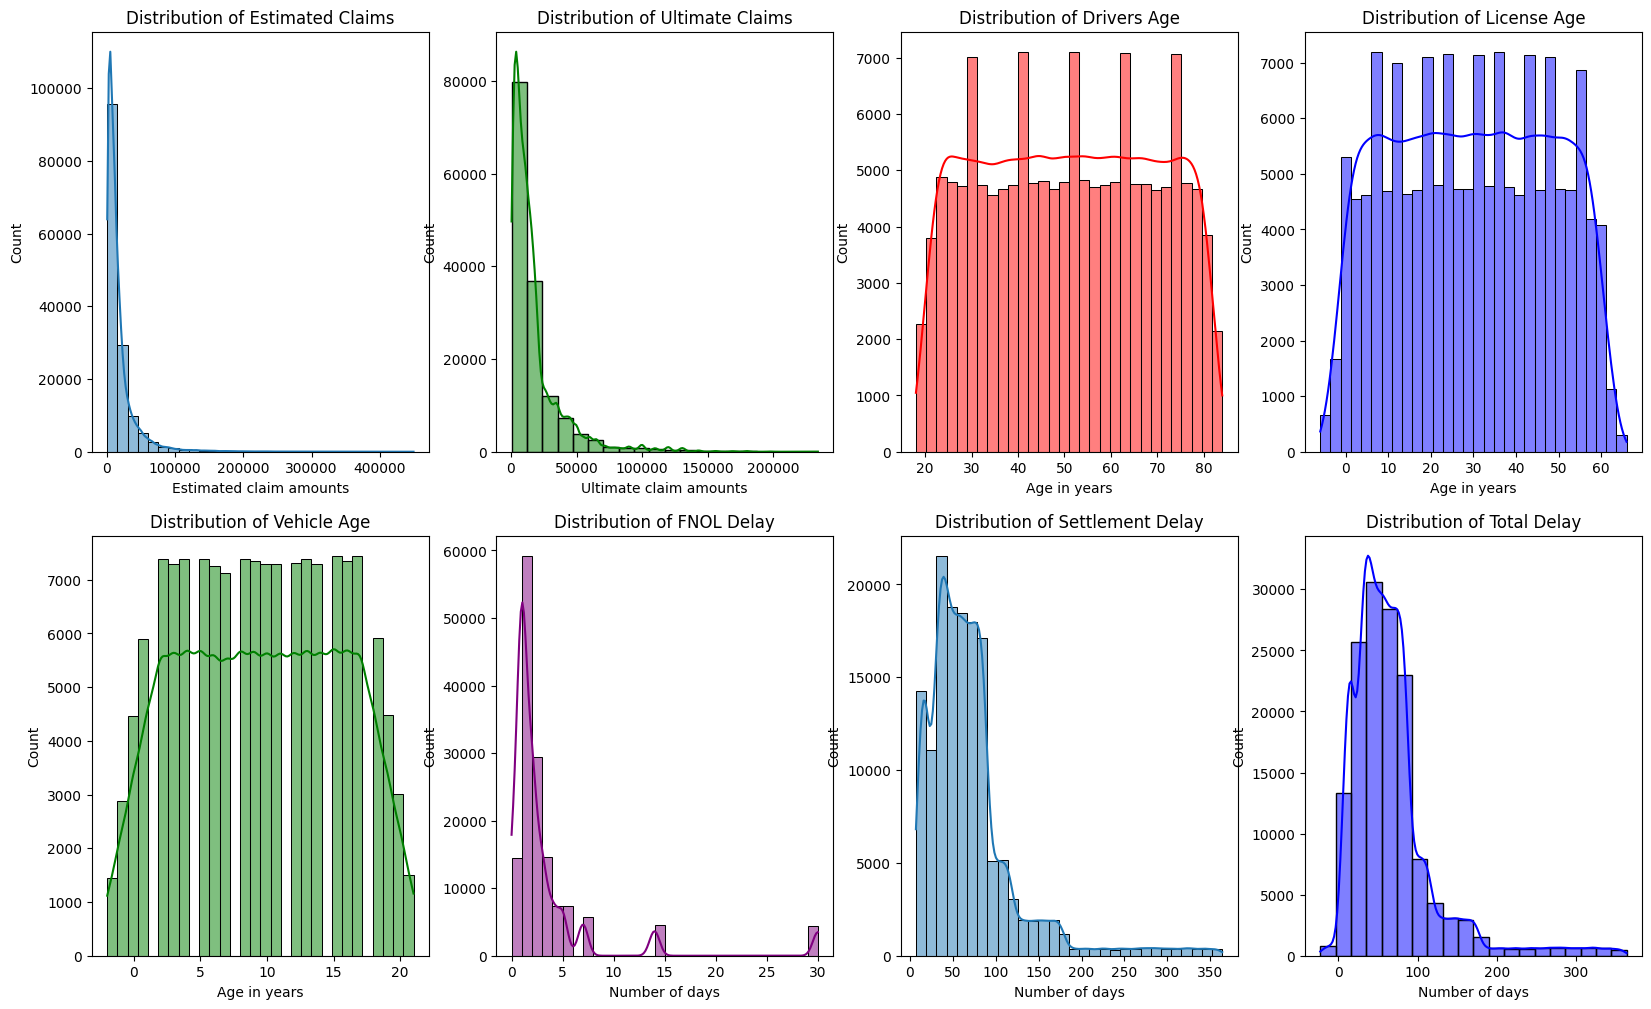

In [24]:
plt.figure(figsize= (20, 12))

# Estimated Claims distribution
plt.subplot(2, 4, 1)
sns.histplot(Claims_df['Estimated_Claim_Amount'], bins= 30, kde = True)
plt.title('Distribution of Estimated Claims')
plt.xlabel('Estimated claim amounts')

#Ultimate Claims distribution
plt.subplot(2, 4, 2)
sns.histplot(Claims_df['Ultimate_Claim_Amount'], bins= 20, kde = True, color = 'green')
plt.title('Distribution of Ultimate Claims')
plt.xlabel('Ultimate claim amounts')

#Driver's Age distribution
plt.subplot(2, 4, 3)
sns.histplot(Claims_df['Driver_age_(years)'], bins= 30, kde = True, color = 'red')
plt.title('Distribution of Drivers Age')
plt.xlabel('Age in years')

#License Age distribution
plt.subplot(2, 4, 4)
sns.histplot(Claims_df['License_age_(years)'], bins= 30, kde = True, color = 'blue')
plt.title('Distribution of License Age')
plt.xlabel('Age in years')

#Vehicle Age distribution
plt.subplot(2, 4, 5)
sns.histplot(Claims_df['Vehicle_age_(years)'], bins= 30, kde = True, color = 'green')
plt.title('Distribution of Vehicle Age')
plt.xlabel('Age in years')

#FNOL Delay Age distribution
plt.subplot(2, 4, 6)
sns.histplot(Claims_df['FNOL_delay_(days)'], bins= 30, kde = True, color = 'purple')
plt.title('Distribution of FNOL Delay')
plt.xlabel('Number of days')

#Settlement duration distribution
plt.subplot(2, 4, 7)
sns.histplot(Claims_df['Settlement_days'], bins= 30, kde = True)
plt.title('Distribution of Settlement Delay')
plt.xlabel('Number of days')

#Total Claim process duration distribution
plt.subplot(2, 4, 8)
sns.histplot(Claims_df['Claim_duration_(days)'], bins= 20, kde = True, color = 'blue')
plt.title('Distribution of Total Delay')
plt.xlabel('Number of days')


Plots of Categorical columns - Traffic_Condition, Weather_Condition, Claim_Type, Vehicle_Type

Text(0.5, 0, 'Vahicle Type')

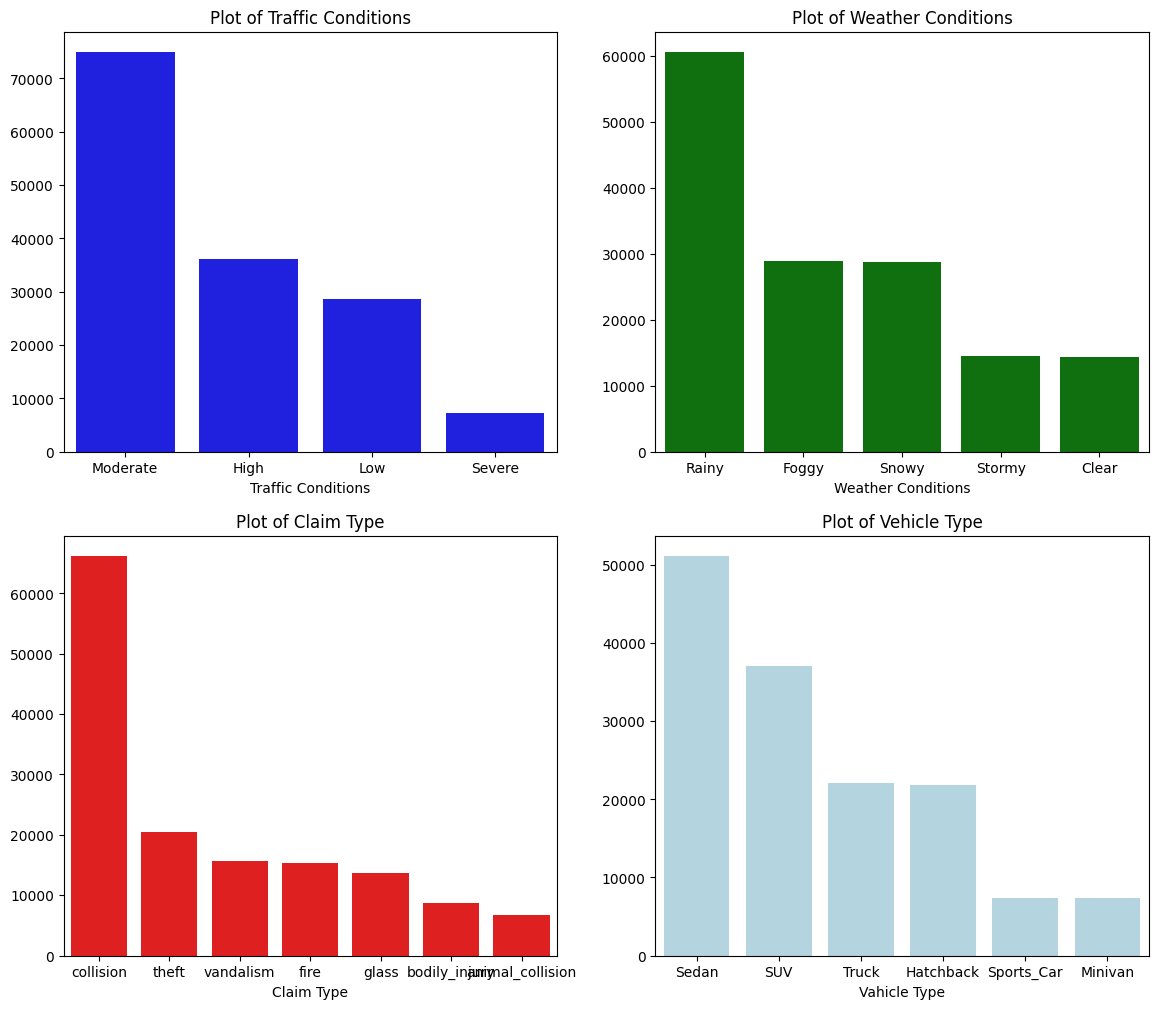

In [25]:
plt.figure(figsize =(14,12))

plt.subplot(2,2,1)
Traffic_Condition = Claims_df['Traffic_Condition'].value_counts()
sns.barplot(x=Traffic_Condition.index, y=Traffic_Condition.values, color = 'Blue')
plt.title('Plot of Traffic Conditions')
plt.xlabel('Traffic Conditions')

plt.subplot(2,2,2)
Weather_Condition = Claims_df['Weather_Condition'].value_counts()
sns.barplot(x=Weather_Condition.index, y=Weather_Condition.values, color = 'green')
plt.title('Plot of Weather Conditions')
plt.xlabel('Weather Conditions')

plt.subplot(2,2,3)
Claim_Type = Claims_df['Claim_Type'].value_counts()
sns.barplot(x=Claim_Type.index, y=Claim_Type.values, color = 'red')
plt.title('Plot of Claim Type')
plt.xlabel('Claim Type')

plt.subplot(2,2,4)
Vehicle_Type = Claims_df['Vehicle_Type'].value_counts()
sns.barplot(x=Vehicle_Type.index, y=Vehicle_Type.values, color = 'lightblue')
plt.title('Plot of Vehicle Type')
plt.xlabel('Vahicle Type')

Visualisation - Trend Plot 


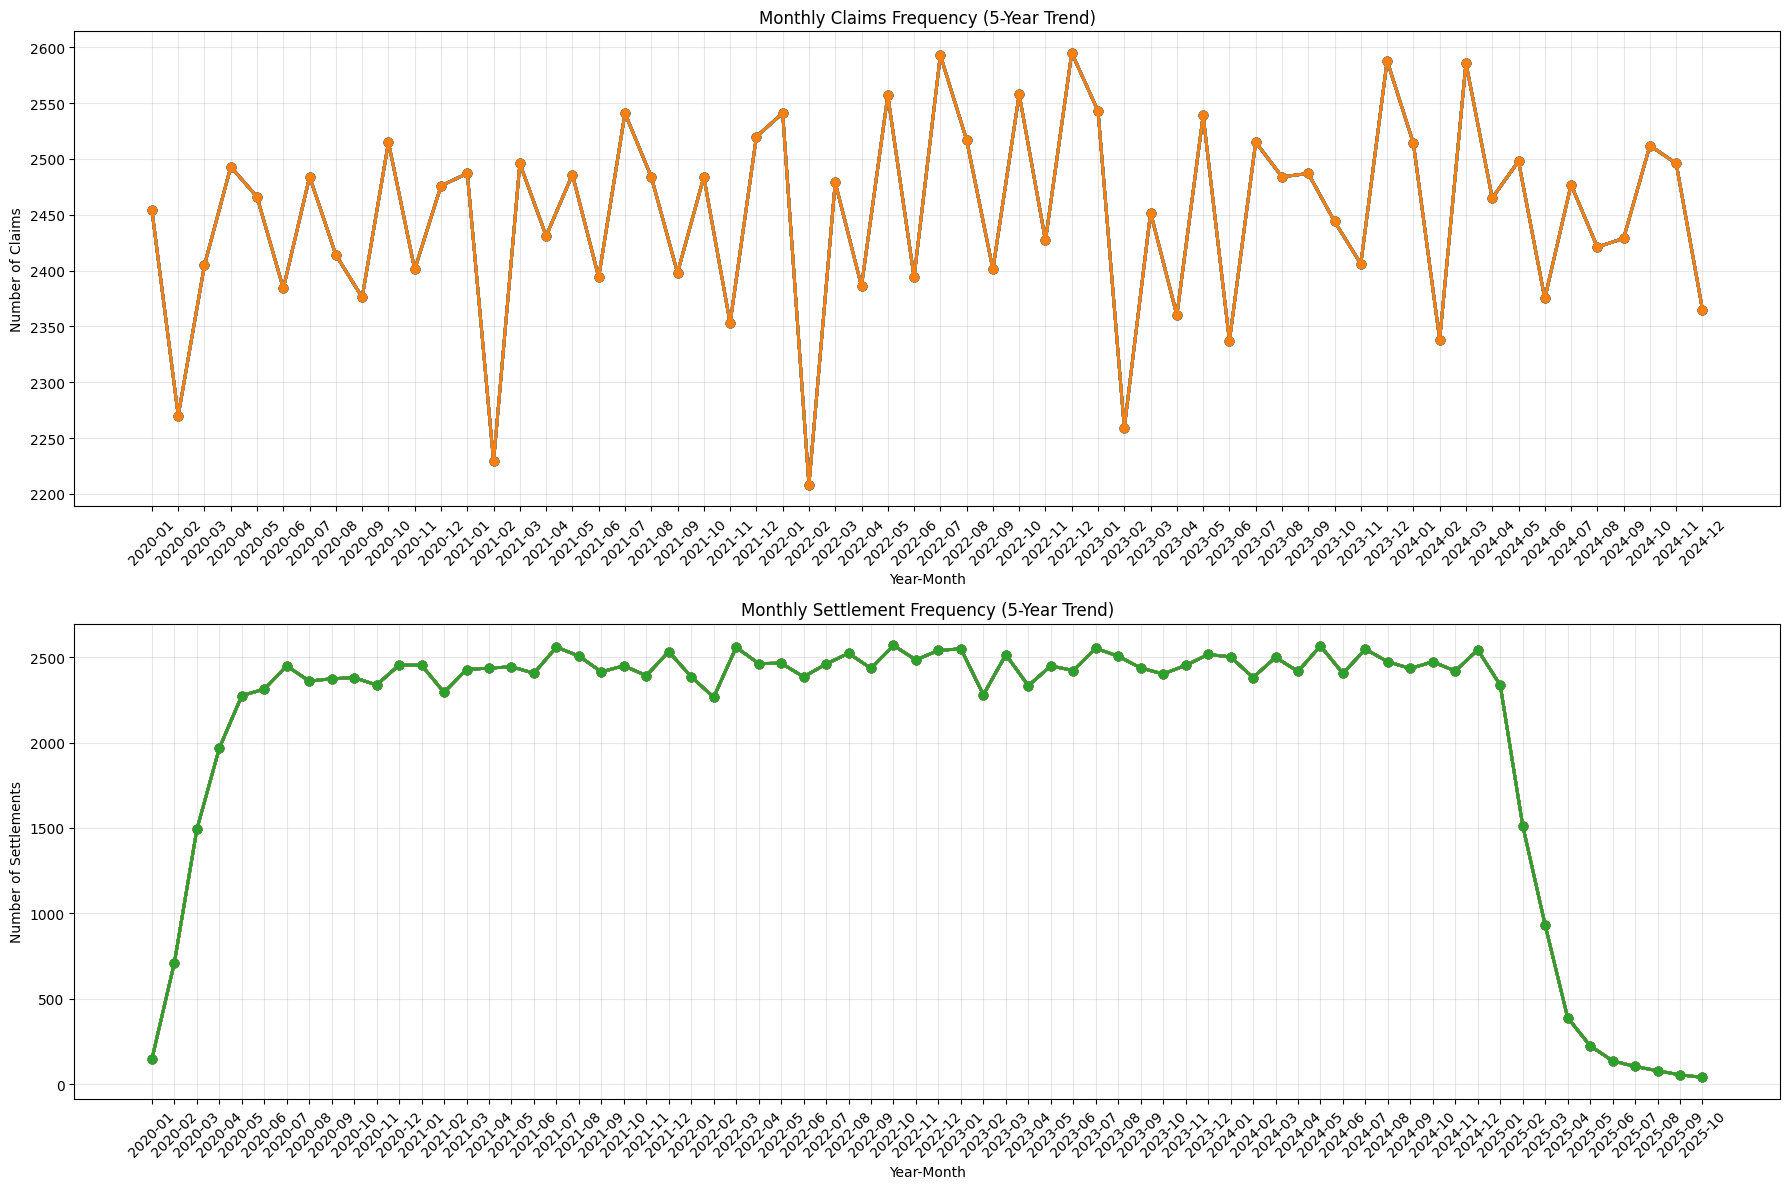

In [26]:
plt.figure(figsize= (18, 12))

plt.subplot(2, 1, 1)
# Defining Accident format in Years and months
Claims_df['Accident_MonthYear'] = Claims_df['Accident_Date'].dt.strftime('%Y-%m')
monthly_claim = Claims_df.groupby('Accident_MonthYear').count()
plt.plot(monthly_claim.index.astype(str), monthly_claim.values, marker = 'o', linewidth = 2)
plt.title('Monthly Claims Frequency (5-Year Trend)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Claims')
plt.grid(True, alpha= 0.3)
plt.xticks(rotation =45)

plt.subplot(2, 1, 2)
Claims_df['Settlement_MonthYear'] = Claims_df['Settlement_Date'].dt.strftime('%Y-%m')
monthly_settlement = Claims_df.groupby('Settlement_MonthYear').count()
plt.plot(monthly_settlement.index.astype(str), monthly_settlement.values, marker = 'o', linewidth = 2)
plt.title('Monthly Settlement Frequency (5-Year Trend)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Settlements')
plt.grid(True, alpha= 0.3)
plt.xticks(rotation =45)

plt.tight_layout()
plt.show()

### Bi-variate Analysis

1. Claim Type vs Ultimate Claim
2. Weather Condition vs Ultimate Claim
3. Vehicle Type vs Ultimate Claim
4. Traffic Condition vs Ultimate Claim

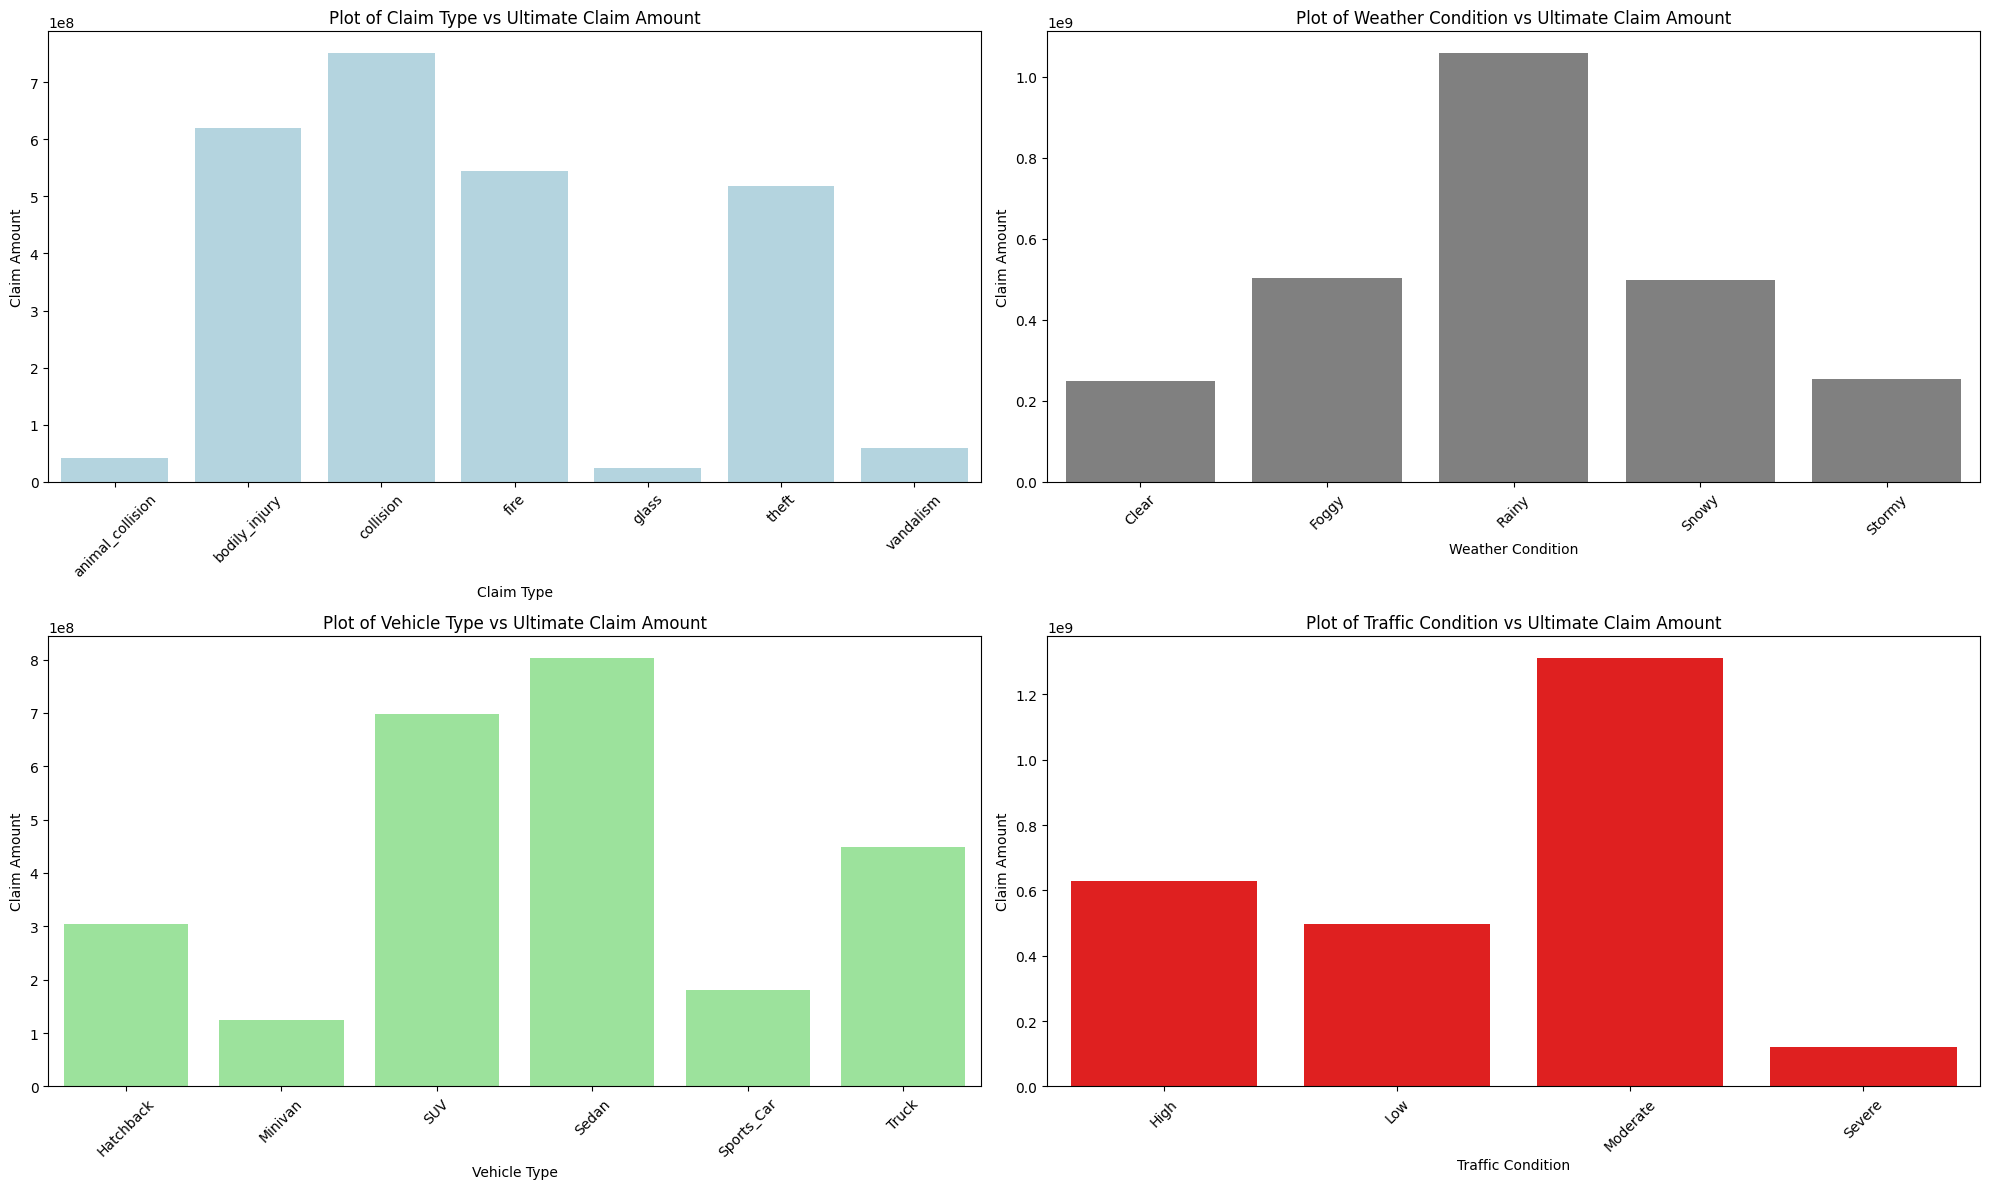

In [27]:
plt.figure(figsize = (20, 12))

claim_type_per_amount = Claims_df.groupby('Claim_Type').agg({
    'Estimated_Claim_Amount': 'sum',
    'Ultimate_Claim_Amount': 'sum',
}).reset_index()

weather_per_amount = Claims_df.groupby('Weather_Condition').agg({
    'Estimated_Claim_Amount': 'sum',
    'Ultimate_Claim_Amount': 'sum',
}).reset_index()

vehicle_type_per_amount = Claims_df.groupby('Vehicle_Type').agg({
    'Estimated_Claim_Amount': 'sum',
    'Ultimate_Claim_Amount': 'sum',
}).reset_index()

Traffic_condition_per_amount = Claims_df.groupby('Traffic_Condition').agg({
    'Estimated_Claim_Amount': 'sum',
    'Ultimate_Claim_Amount': 'sum',
}).reset_index()


plt.subplot(2, 2, 1)
sns.barplot(x= 'Claim_Type', y = 'Ultimate_Claim_Amount', data = claim_type_per_amount, color = 'lightblue')
plt.title('Plot of Claim Type vs Ultimate Claim Amount')
plt.xlabel('Claim Type')
plt.ylabel('Claim Amount')
plt.xticks(rotation = 45)

plt.subplot(2, 2, 2)
sns.barplot(x= 'Weather_Condition', y = 'Ultimate_Claim_Amount', data = weather_per_amount, color = 'grey')
plt.title('Plot of Weather Condition vs Ultimate Claim Amount')
plt.xlabel('Weather Condition')
plt.ylabel('Claim Amount')
plt.xticks(rotation = 45)

plt.subplot(2, 2, 3)
sns.barplot(x= 'Vehicle_Type', y = 'Ultimate_Claim_Amount', data = vehicle_type_per_amount, color = 'lightgreen')
plt.title('Plot of Vehicle Type vs Ultimate Claim Amount')
plt.xlabel('Vehicle Type')
plt.ylabel('Claim Amount')
plt.xticks(rotation = 45)

plt.subplot(2, 2, 4)
sns.barplot(x= 'Traffic_Condition', y = 'Ultimate_Claim_Amount', data = Traffic_condition_per_amount, color = 'red')
plt.title('Plot of Traffic Condition vs Ultimate Claim Amount')
plt.xlabel('Traffic Condition')
plt.ylabel('Claim Amount')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

1. Claim Type vs FNOL Delay
2. Weather Condition vs FNOL Delay
3. Vehicle Type vs FNOL Delay
4. Traffic Condition vs FNOL Delay

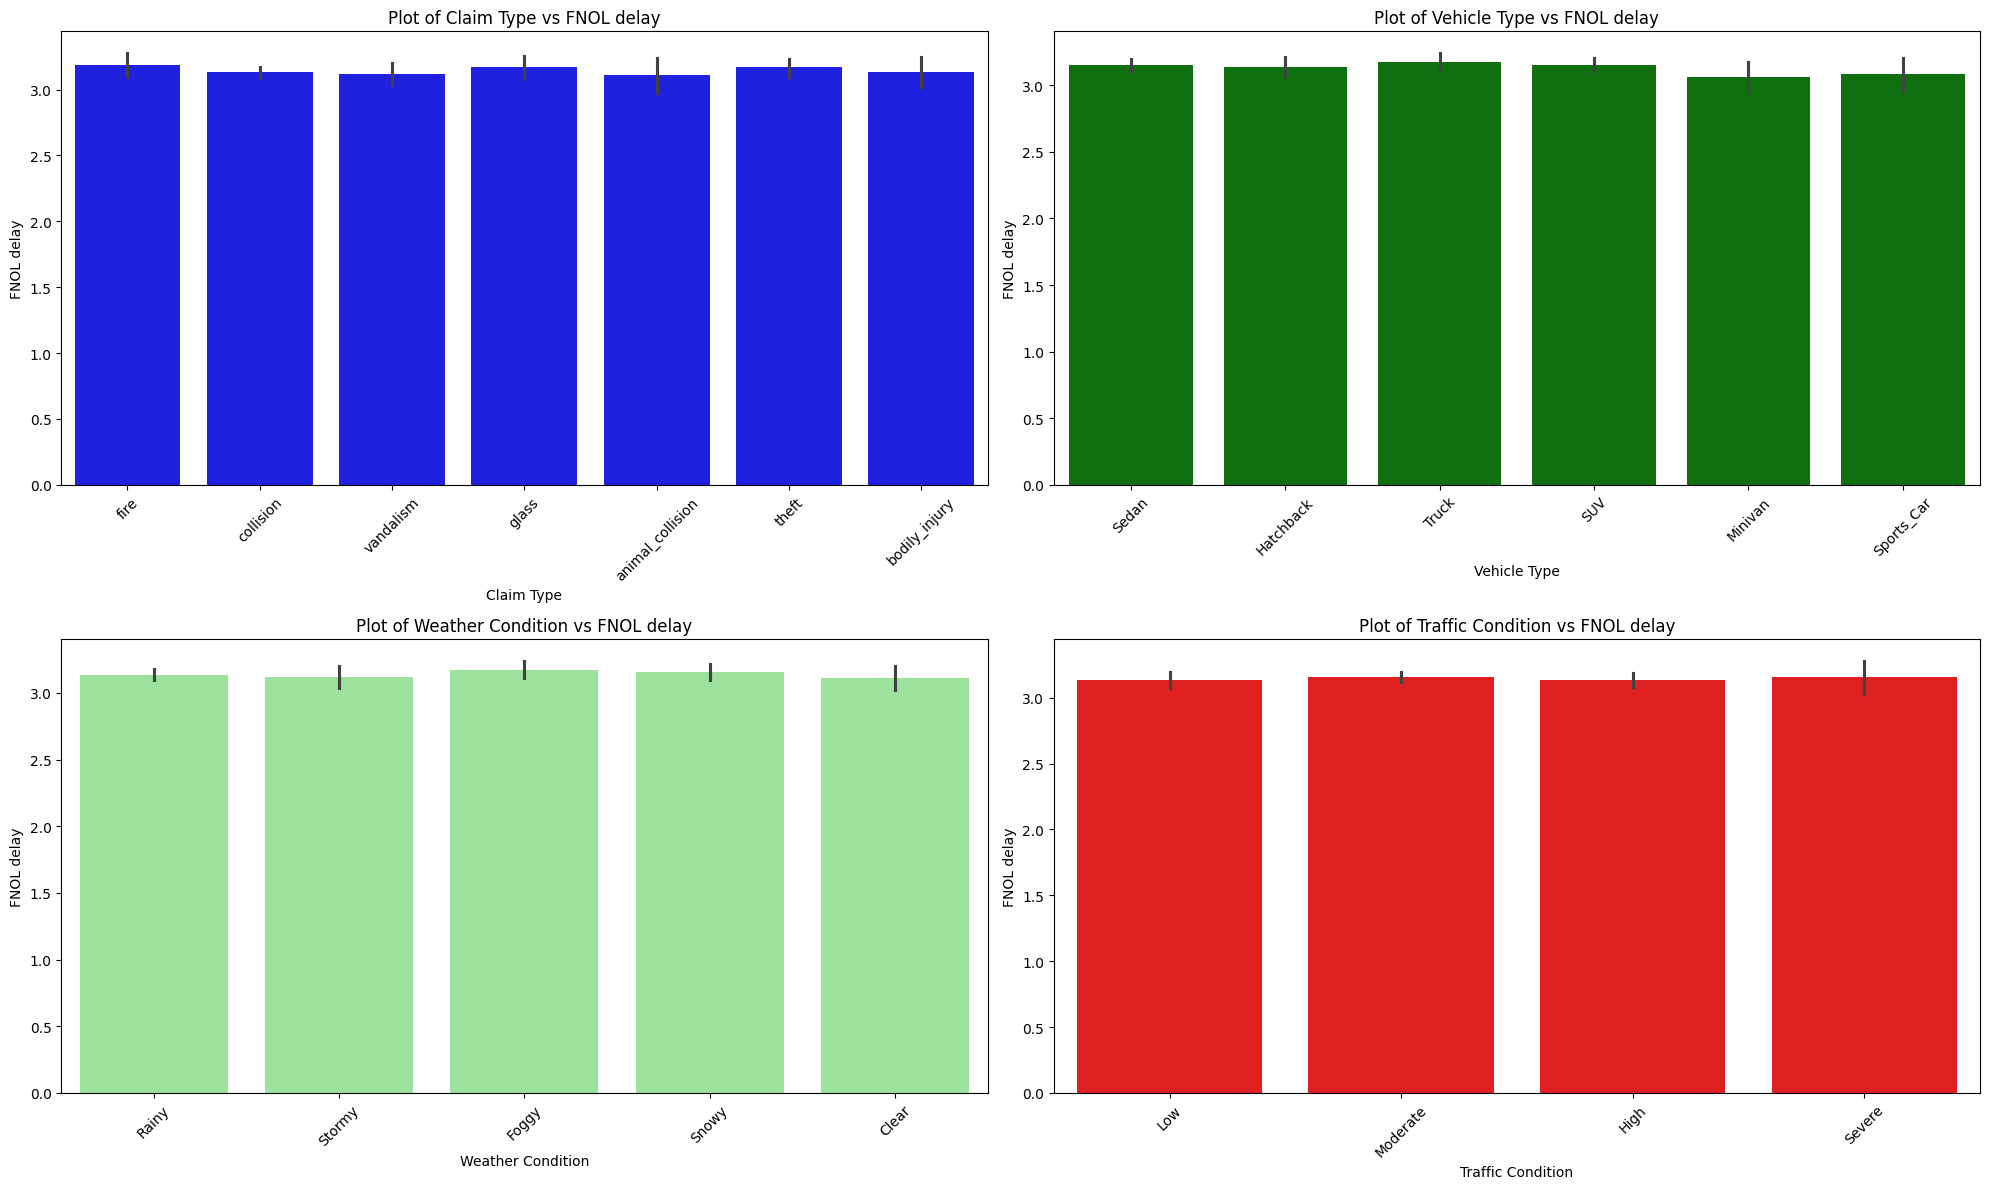

In [28]:
Claim_Type_per_FNOLdelay = Claims_df.groupby('Claim_Type').agg({
    'FNOL_delay_(days)': 'max',
     'Settlement_days': 'max',
}).reset_index()


Vehicle_Type_per_FNOLdelay = Claims_df.groupby('Vehicle_Type').agg({
    'FNOL_delay_(days)': 'max',
     'Settlement_days': 'max',
}).reset_index()

Weather_Condition_per_FNOLdelay = Claims_df.groupby('Weather_Condition').agg({
    'FNOL_delay_(days)': 'max',
     'Settlement_days': 'max',
}).reset_index()

Traffic_Condition_per_FNOLdelay = Claims_df.groupby('Traffic_Condition').agg({
    'FNOL_delay_(days)': 'max',
     'Settlement_days': 'max',
}).reset_index()

plt.figure(figsize = (20, 12))

plt.subplot(2,2,1)
sns.barplot(x= 'Claim_Type', y = 'FNOL_delay_(days)', data = Claims_df, color = 'blue')
plt.title('Plot of Claim Type vs FNOL delay')
plt.xlabel('Claim Type')
plt.ylabel('FNOL delay')
plt.xticks(rotation = 45)

plt.subplot(2, 2, 2)
sns.barplot(x= 'Vehicle_Type', y = 'FNOL_delay_(days)', data = Claims_df, color = 'green')
plt.title('Plot of Vehicle Type vs FNOL delay')
plt.xlabel('Vehicle Type')
plt.ylabel('FNOL delay')
plt.xticks(rotation = 45)

plt.subplot(2, 2, 3)
sns.barplot(x= 'Weather_Condition', y = 'FNOL_delay_(days)', data = Claims_df, color = 'lightgreen')
plt.title('Plot of Weather Condition vs FNOL delay')
plt.xlabel('Weather Condition')
plt.ylabel('FNOL delay')
plt.xticks(rotation = 45)

plt.subplot(2, 2, 4)
sns.barplot(x= 'Traffic_Condition', y = 'FNOL_delay_(days)', data = Claims_df, color = 'red')
plt.title('Plot of Traffic Condition vs FNOL delay')
plt.xlabel('Traffic Condition')
plt.ylabel('FNOL delay')
plt.xticks(rotation = 45)


plt.tight_layout()
plt.show()

### Checking for outliers in dataset using Boxplot

In [29]:
Claims_df.columns

Index(['Claim_ID', 'Policy_ID', 'Customer_ID', 'Accident_Date', 'FNOL_Date',
       'Claim_Type', 'Estimated_Claim_Amount', 'Ultimate_Claim_Amount',
       'Settlement_Date', 'Traffic_Condition', 'Weather_Condition',
       'Date_of_Birth', 'Full_License_Issue_Date', 'Vehicle_Type',
       'Vehicle_Year', 'Driver_age_(years)', 'License_age_(years)',
       'Vehicle_age_(years)', 'FNOL_delay_(days)', 'Settlement_days',
       'Claim_duration_(days)', 'Claim_accuracy_Check', 'Accident_MonthYear',
       'Settlement_MonthYear'],
      dtype='object')

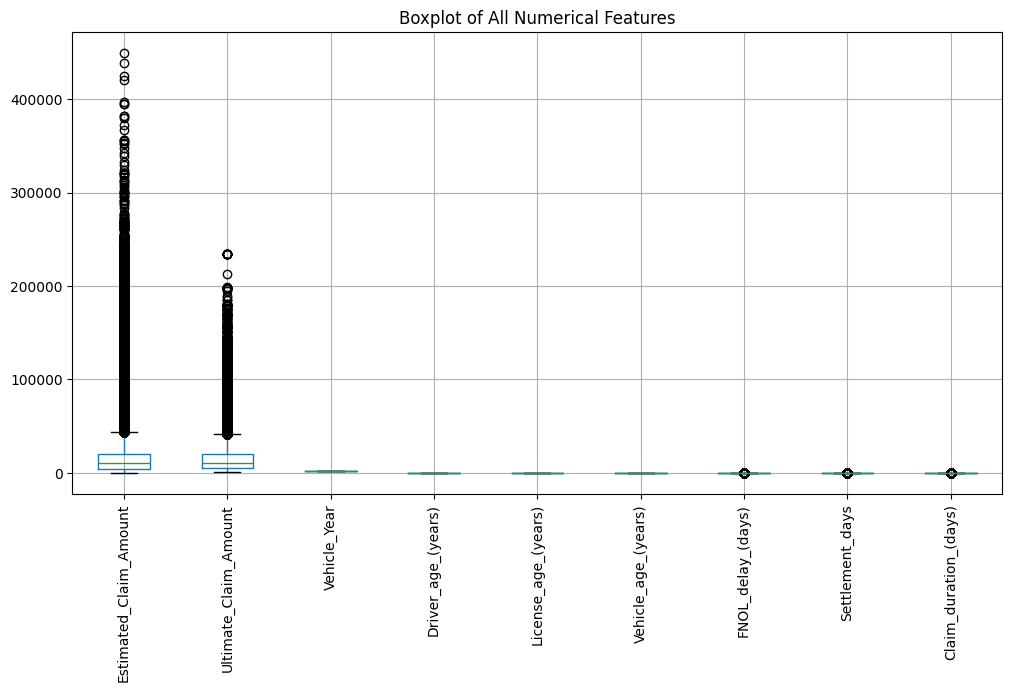

In [30]:
numeric_features = ['Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'Vehicle_Year', 'Driver_age_(years)', 'License_age_(years)', 'Vehicle_age_(years)', 'FNOL_delay_(days)', 'Settlement_days', 'Claim_duration_(days)']

plt.figure(figsize= (12, 6))
Claims_df[numeric_features].boxplot(rot = 90)
plt.title('Boxplot of All Numerical Features')
plt.show()

Getting outlier values

In [31]:
def get_iqr_outlier(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    return mask

iqr_outliers = pd.DataFrame()

for col in numeric_features:
    iqr_outliers[col] = get_iqr_outlier(Claims_df, col)

print(iqr_outliers.sum())


Estimated_Claim_Amount    13022
Ultimate_Claim_Amount     14735
Vehicle_Year                  0
Driver_age_(years)            0
License_age_(years)           0
Vehicle_age_(years)           0
FNOL_delay_(days)         14633
Settlement_days            9900
Claim_duration_(days)      9868
dtype: int64


Fixing the outliers

In [32]:
def winsorize(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

In [33]:
outlier_columns = ['Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'FNOL_delay_(days)', 'Settlement_days', 'Claim_duration_(days)']

# Apply winsorization to all outlier columns
for col in outlier_columns:
    Claims_df = winsorize(Claims_df, col)

print("Successfully corrected outliers")

Successfully corrected outliers


Sanity check on outliers

In [34]:
# Checking in values

for col in numeric_features:
    iqr_outliers[col] = get_iqr_outlier(Claims_df, col)

print(iqr_outliers.sum())

Estimated_Claim_Amount    0
Ultimate_Claim_Amount     0
Vehicle_Year              0
Driver_age_(years)        0
License_age_(years)       0
Vehicle_age_(years)       0
FNOL_delay_(days)         0
Settlement_days           0
Claim_duration_(days)     0
dtype: int64


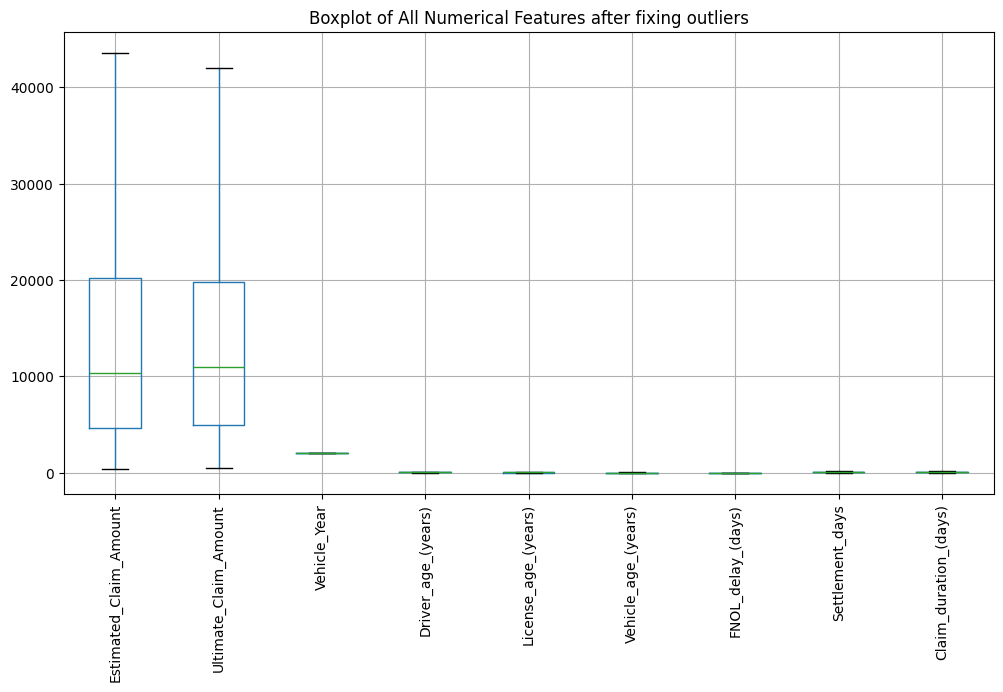

In [35]:
# Check using boxplot

plt.figure(figsize= (12, 6))
Claims_df[numeric_features].boxplot(rot = 90)
plt.title('Boxplot of All Numerical Features after fixing outliers')
plt.show()

In [36]:
# Saving Cleaned Dataset

Claims_df.to_csv("FNOL_DATA/Claims_Policy_merged_cleaned.csv", index = False)

##### Addressing Skewness in target variable (Ultimate_Claim_Amount) using log transformation

In [37]:
Claims_df['Ultimate_Claim_Amount'] = np.log1p(Claims_df['Ultimate_Claim_Amount'])

Text(0.5, 0, 'Ultimate claim amounts')

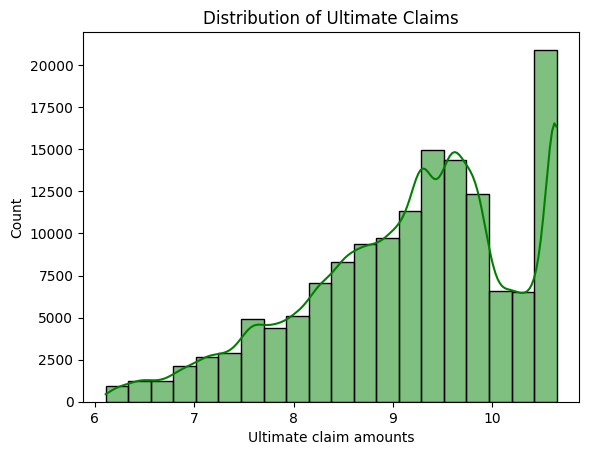

In [38]:
# Viewing Ultimate_Claim_Amount after log transformation

sns.histplot(Claims_df['Ultimate_Claim_Amount'], bins= 20, kde = True, color = 'green')
plt.title('Distribution of Ultimate Claims')
plt.xlabel('Ultimate claim amounts')

#### Feature Selection

In [39]:
# Checking the dataset

Claims_df.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,...,Vehicle_Year,Driver_age_(years),License_age_(years),Vehicle_age_(years),FNOL_delay_(days),Settlement_days,Claim_duration_(days),Claim_accuracy_Check,Accident_MonthYear,Settlement_MonthYear
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,9.351058,2020-06-26,Low,...,2008,36,16,12,4,112.0,108.0,False,2020-03,2020-06
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,9.646723,2023-03-21,Low,...,2012,36,15,11,1,70.0,69.0,False,2023-01,2023-03
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,9.510519,2023-02-01,Low,...,2021,51,33,1,1,37.0,36.0,False,2022-12,2023-02
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,7.906886,2021-12-13,Moderate,...,2021,50,32,0,5,14.0,9.0,False,2021-11,2021-12
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,9.302631,2022-12-06,Moderate,...,2021,51,33,1,6,59.0,52.0,False,2022-10,2022-12


In [40]:
Claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Claim_ID                 146987 non-null  object        
 1   Policy_ID                146987 non-null  object        
 2   Customer_ID              146987 non-null  object        
 3   Accident_Date            146987 non-null  datetime64[ns]
 4   FNOL_Date                146987 non-null  datetime64[ns]
 5   Claim_Type               146987 non-null  object        
 6   Estimated_Claim_Amount   146987 non-null  float64       
 7   Ultimate_Claim_Amount    146987 non-null  float64       
 8   Settlement_Date          146987 non-null  datetime64[ns]
 9   Traffic_Condition        146987 non-null  object        
 10  Weather_Condition        146987 non-null  object        
 11  Date_of_Birth            146987 non-null  datetime64[ns]
 12  Full_License_Iss

Correlation Matrix 

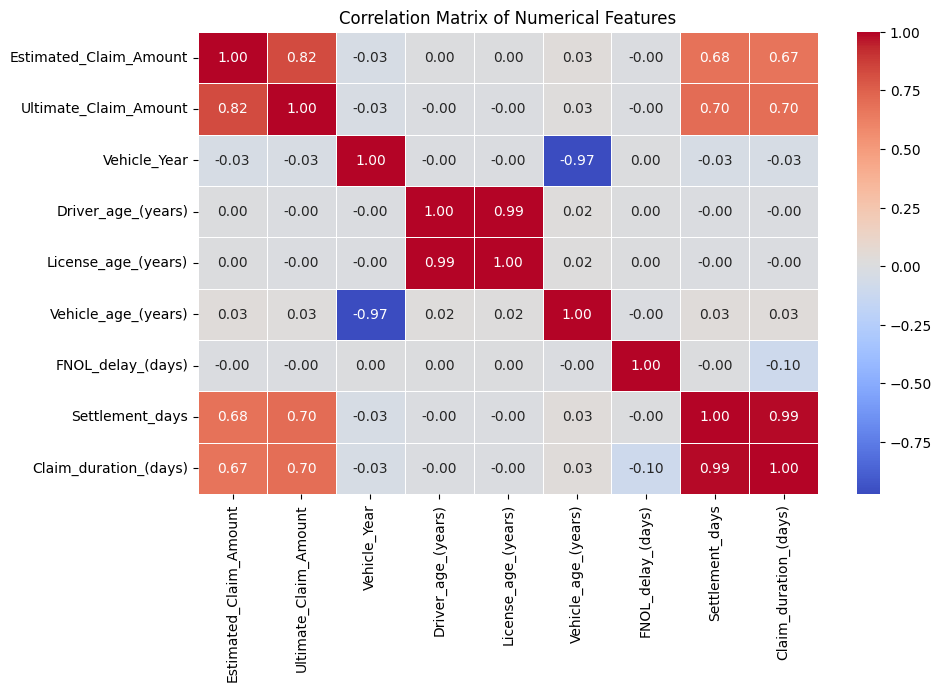

In [41]:
# Select the numerical variables in Claims_df
numeric_df = Claims_df.select_dtypes(include = ['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize= (10, 6))
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap= 'coolwarm', linewidths = 0.6)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Notes:

- Ultimate_Claim_Amount is highly correlated with Estimated_Claim_Amount - about 82%.
- Driver_age_(years) and License_age_(years) are highly correlated to about 99%
- Settlement_days & Claim_duration in total are highly correlated to about 99%
- Moderate correlation between Settlement_days to Estimated_Claim_Amount & Ultimate_Claim_Amount
- Moderate correlation between Claim_duration to Estimated_Claim_Amount & Ultimate_Claim_Amount

In [42]:
Claims_df.columns

Index(['Claim_ID', 'Policy_ID', 'Customer_ID', 'Accident_Date', 'FNOL_Date',
       'Claim_Type', 'Estimated_Claim_Amount', 'Ultimate_Claim_Amount',
       'Settlement_Date', 'Traffic_Condition', 'Weather_Condition',
       'Date_of_Birth', 'Full_License_Issue_Date', 'Vehicle_Type',
       'Vehicle_Year', 'Driver_age_(years)', 'License_age_(years)',
       'Vehicle_age_(years)', 'FNOL_delay_(days)', 'Settlement_days',
       'Claim_duration_(days)', 'Claim_accuracy_Check', 'Accident_MonthYear',
       'Settlement_MonthYear'],
      dtype='object')

In [43]:
# Selection of features

features = ['Claim_Type', 
            'Estimated_Claim_Amount',
            'Traffic_Condition',
            'Weather_Condition',
            'Vehicle_Type',
            'Vehicle_Year', 
            'Driver_age_(years)', 
            'License_age_(years)',
]

target = ['Ultimate_Claim_Amount']

In [44]:
# Creating the new dataset

Claims_df = Claims_df[features + target]

Encoding Categorical columns using One-Hot Encoding

In [45]:
categorical_features = ['Claim_Type', 'Traffic_Condition', 'Weather_Condition', 'Vehicle_Type']
Claims_df = pd.get_dummies(Claims_df, columns= categorical_features, drop_first = False, dtype= int)

In [46]:
#for col in ['Claim_Type', 'Traffic_Condition', 'Weather_Condition', 'Vehicle_Type']:
    #dummies = pd.get_dummies(Claims_df[col], prefix=col, dtype=int)
    #Claims_df = pd.concat([Claims_df.drop(columns=col), dummies], axis=1)

In [47]:
# Independent variables
X = Claims_df.drop("Ultimate_Claim_Amount", axis = 1)
# Target variable
y = Claims_df['Ultimate_Claim_Amount']

In [48]:
# Check data
X.head()

,Estimated_Claim_Amount,Vehicle_Year,Driver_age_(years),License_age_(years),Claim_Type_animal_collision,Claim_Type_bodily_injury,Claim_Type_collision,Claim_Type_fire,Claim_Type_glass,Claim_Type_theft,...,Weather_Condition_Foggy,Weather_Condition_Rainy,Weather_Condition_Snowy,Weather_Condition_Stormy,Vehicle_Type_Hatchback,Vehicle_Type_Minivan,Vehicle_Type_SUV,Vehicle_Type_Sedan,Vehicle_Type_Sports_Car,Vehicle_Type_Truck
0,8761.43,2008,36,16,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,12896.76,2012,36,15,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,12698.97,2021,51,33,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,2738.35,2021,50,32,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,16262.58,2021,51,33,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [49]:
y.head()

0    9.351058
1    9.646723
2    9.510519
3    7.906886
4    9.302631
Name: Ultimate_Claim_Amount, dtype: float64

Splitting the dataset into training and testing set

In [50]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

# Model Development

- Linear Regression
- Random Forest
- Gradient Boosting

### 1. Random Forest Model

An ensemble of decision trees where each tree votes, and the average prediction is taken.

- How it works: Builds many trees on random samples of data, Each tree sees different features, Final result is an average of all trees

- Key traits: Handles non-linear relationships well, Robust to outliers, Reduces overfitting compared to a single tree, Less interpretable than Linear Regression

- Best used when: Data has complex patterns, There are interactions between features, Accuracy is more important than explainability

In [51]:
# Initialize and train the model
Random_forest_model = RandomForestRegressor(n_estimators=100, random_state= 42)
Random_forest_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [52]:
# Model prediction
Random_forest_pred_log = Random_forest_model.predict(X_test)

In [53]:
# Convert the normalised values back to the standard format (values)
Random_forest_pred_values = np.expm1(Random_forest_pred_log)

In [54]:
# Checking values (first 10 values)
Random_forest_pred_values[:10]

array([36373.4131511 , 18869.36835049, 11882.87898219, 12427.36263972,
        9442.34388981, 12421.7835568 ,  5525.43290195, 27198.83701432,
       33976.0083558 , 19094.50156785])

In [55]:
# Standard version of y_test & Check against model prediction
y_test = np.expm1(y_test)
y_test[:10]

2136      41983.1675
26563     12050.8500
48955     14850.0000
113544    15939.2200
85113      9227.8400
38001     20180.8000
127421     6000.0000
103538    22116.4900
96573     41983.1675
131673    18253.4000
Name: Ultimate_Claim_Amount, dtype: float64

##### Random Forest Model Evaluation



In [56]:
# Defining an evaluation function

def evaluation_metrics(X_test, y_test, model):
    # Predict in log scale and transform back
    model_pred_log = model.predict(X_test)
    model_pred = np.expm1(model_pred_log)

    # Metrics
    mae = mean_absolute_error(y_test, model_pred)
    mse = mean_squared_error(y_test, model_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, model_pred)

    print("MAE :", mae )
    print("MSE :", mse)
    print("RMSE :", rmse)
    print("R2 :", r2)

evaluation_metrics(X_test, y_test, Random_forest_model)

MAE : 2528.386870127971
MSE : 18097682.920954414
RMSE : 4254.137153519432
R2 : 0.8887755842281252


### 2. Linear Regressor Model

A statistical model that fits a straight line to the data.

How it works: It assumes a linear relationship between input features and the target: If X increases, Y increases or decreases at a constant rate.

Key traits: Simple and fast, Easy to interpret, Sensitive to outliers, Struggles with complex patterns

Best used when: Relationship is roughly linear, Interpretability matters, Data is clean and well-behaved

In [57]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
Linear_Regression_model = LinearRegression(fit_intercept=True)
Linear_Regression_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [58]:
# Model prediction
Linear_Regression_pred_log = Linear_Regression_model.predict(X_test)

In [59]:
# Convert the normalised values back to the standard format (values)
Linear_Regression_pred_values = np.expm1(Linear_Regression_pred_log)

In [60]:
# Check against y_test
y_test[:10]

2136      41983.1675
26563     12050.8500
48955     14850.0000
113544    15939.2200
85113      9227.8400
38001     20180.8000
127421     6000.0000
103538    22116.4900
96573     41983.1675
131673    18253.4000
Name: Ultimate_Claim_Amount, dtype: float64

In [61]:
# Linear Regression Model Evaluation
Linear_Regression_metrics = evaluation_metrics(X_test, y_test, Linear_Regression_model)
Linear_Regression_metrics

MAE : 3925.3560129398043
MSE : 37300753.792126276
RMSE : 6107.43430518301
R2 : 0.7707576949767337


### 3. Gradient Boosting Model

An ensemble method that builds trees sequentially, each correcting the previous model’s mistakes.

How it works: First model makes predictions, Next model focuses on the errors (residuals), Models are added step-by-step to improve performance

Key traits: Very high predictive power, Excellent at capturing complex patterns, Can overfit if not tuned properly, Slower and more sensitive to hyperparameters

Best used when: You want top performance, Data is complex and noisy, You are willing to tune parameters

In [62]:
# Initialize and train the model
Gradient_Boosting_model = GradientBoostingRegressor(n_estimators=100, random_state= 42)
Gradient_Boosting_model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [63]:
# Model prediction
Gradient_Boosting_pred_log = Gradient_Boosting_model.predict(X_test)

In [64]:
# Convert the normalised values back to the standard format (values)
Gradient_Boosting_pred_values = np.expm1(Gradient_Boosting_pred_log)

In [65]:
# Checking values (first 10 values)
Gradient_Boosting_pred_values[:10]

array([36125.29580777, 18684.780031  , 12228.44820591, 13257.05836485,
       10372.79636454, 12133.66445691,  5632.09794756, 29409.39877518,
       40156.54360652, 17666.43963699])

In [66]:
# Check against y_test
y_test[:10]

2136      41983.1675
26563     12050.8500
48955     14850.0000
113544    15939.2200
85113      9227.8400
38001     20180.8000
127421     6000.0000
103538    22116.4900
96573     41983.1675
131673    18253.4000
Name: Ultimate_Claim_Amount, dtype: float64

In [67]:
# Linear Regression Model Evaluation
Gradient_Boosting_metrics = evaluation_metrics(X_test, y_test, Gradient_Boosting_model)
Gradient_Boosting_metrics

MAE : 2579.159982129299
MSE : 18254043.760185916
RMSE : 4272.475132775604
R2 : 0.887814624581021


### Hyper Parameter Tuning

- Number of Trees (n-estimator) - number of decision trees, higher number of trees increases the performance and efficiency of the model

- Maximum Tree depth - controls the max depth of the trees as it defines the branches

- Minimum Sample to split - the number of samples required to split an internal node

- Minimum sample at leaf - The higher the better

- Maximum features per split


Using GridSearchCV - each parameter will be evaluated using cross-validation to find the optimal set of hyparameters.

In [68]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

In [69]:
Random_forest_hyper = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_distributions= param_grid,
    n_iter = 10,
    cv = 5,
    verbose= 1,
    n_jobs= -1
)

In [70]:
Random_forest_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [71]:

Best_rf_model = Random_forest_hyper.best_estimator_

In [72]:
evaluation_metrics(X_test = X_test, y_test = y_test, model = Best_rf_model)

MAE : 2625.2647434725695
MSE : 18119044.726964124
RMSE : 4256.647122673446
R2 : 0.8886442992230978


## Model Tracking Using MLFlow

In [73]:
import mlflow

In [74]:
# Create path to save the tracking
mlflow.set_tracking_uri("file:///C:/Users/adebo/OneDrive/Desktop/FNOL PROJECT/miruns")

In [75]:
mlflow.set_experiment("FNOL_ultimate_claim_experiments")

2025/12/26 14:58:13 INFO mlflow.tracking.fluent: Experiment with name 'FNOL_ultimate_claim_experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/adebo/OneDrive/Desktop/FNOL PROJECT/miruns/819446455504963275', creation_time=1766761093799, experiment_id='819446455504963275', last_update_time=1766761093799, lifecycle_stage='active', name='FNOL_ultimate_claim_experiments', tags={}>

In [76]:
# check tracking uri to see if its working
mlflow.get_tracking_uri()

'file:///C:/Users/adebo/OneDrive/Desktop/FNOL PROJECT/miruns'

In [77]:
models = {
    "RF_model": Random_forest_model,
    "LR_model": Linear_Regression_model,
    "GB_model": Gradient_Boosting_model,
    "Tuned_RF_model": Best_rf_model,
}

In [78]:
for model_name, model in models.items():
    with mlflow.start_run(run_name = model_name):

        # Log parameters (model hyperparameters)
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())

        model_pred_log = model.predict(X_test)
        preds = np.expm1(model_pred_log)

        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_metrics({
            "MAE": mae,
            "MSE": mse,
            "R2": r2
        })

        mlflow.sklearn.log_model(model, model_name)

print("All models logs successfully")

2025/12/26 14:58:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 14:58:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 14:58:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 14:58:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


All models logs successfully


In [79]:
mlflow.get_tracking_uri()

'file:///C:/Users/adebo/OneDrive/Desktop/FNOL PROJECT/miruns'

SHAP + LIME

In [80]:
best_model = Random_forest_model

In [81]:
import shap
import pandas as pd

100%|██████████| 15/15 [01:00<00:00,  4.03s/it]


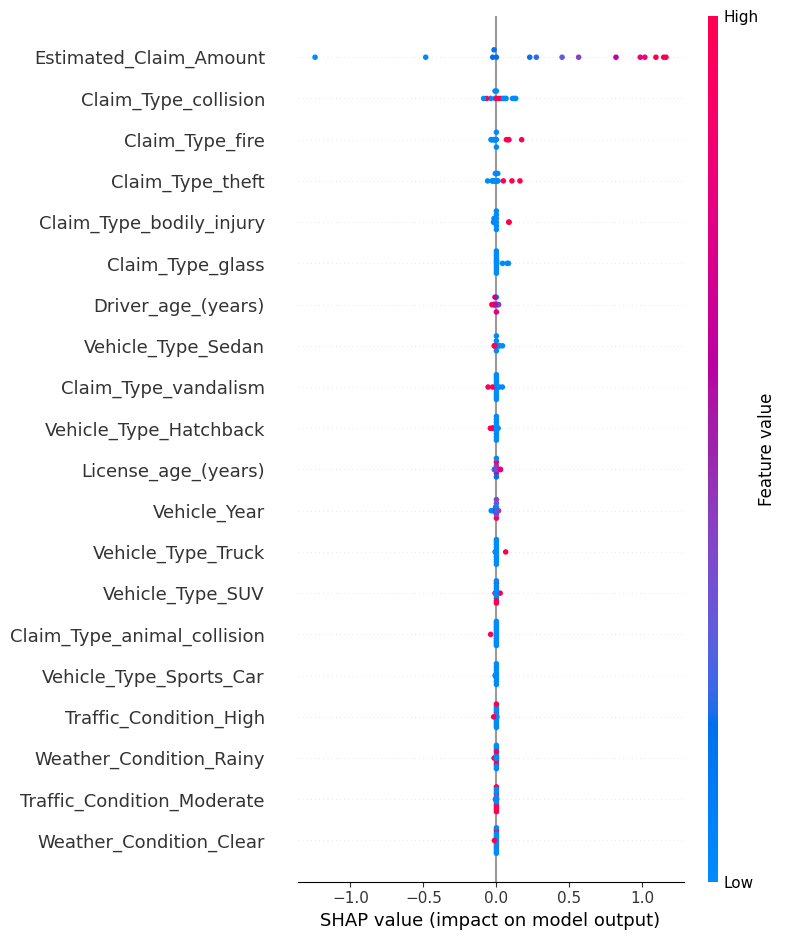

In [82]:
# Create a wrapper function that handles the pipeline
def pipeline_predict(X):
    # if X is a numpy array, convert it back to DataFrame with original column names
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=X_train.columns)
    return best_model.predict(X)

# Use smaller background data
X_background = shap.sample(X_train, 100)
X_test_sample_small = X_test.iloc[:15]

# Use KernelExplainer with the wrapper
explainer = shap.KernelExplainer(pipeline_predict, X_background)
shap_values = explainer.shap_values(X_test_sample_small)

# Plot results
shap.summary_plot(shap_values, X_test_sample_small)

Feature Importance

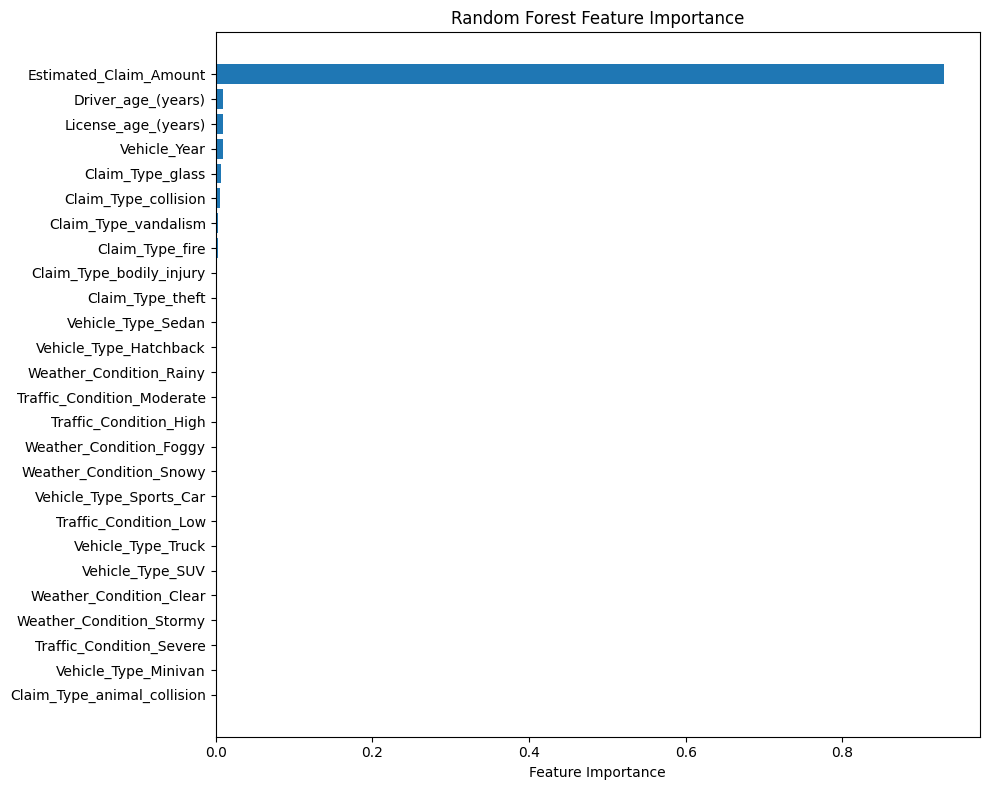

In [83]:
# Replace with objects
model = Random_forest_model
feature_names = X_train.columns

# Extract importances
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

Saving the best model

In [85]:
import joblib

In [86]:
# Saving the model locally for deployment
os.makedirs("models", exist_ok=True)
joblib.dump(Random_forest_model, "models/best_model.pkl")

print("Model saved locally as models/best_model.pkl")

Model saved locally as models/best_model.pkl


In [87]:
feature_columns = X_train.columns.tolist()

with open("models/feature_columns.pkl", "wb") as f:
    joblib.dump(feature_columns, f)